<a href="https://colab.research.google.com/github/wallacelw/Price-Forecasting-With-LSTM/blob/main/Prices_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets available @

BTC, AAPL, MSFT, TSLA, ^IXIC(NASDAQ), ^BVSP(IBOVESPA):
https://finance.yahoo.com/

S&P 500:
https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_index.csv

## Load Dataset and Preprocess It:

In [2]:
import pandas as pd
import datetime

def str_to_datetime(s):
  year, month, day = [int(i) for i in s.split('-')]
  return datetime.datetime(year=year, month=month, day=day)

price_dict = {
    "Adj Close" : "Price",
    "S&P500" : "Price"
}

def load_df(filename):
  df = pd.read_csv(filename)
  df.rename(columns = price_dict, inplace = True)
  df = df[["Date", "Price"]]

  # Convert date type objects to datetime object
  df["Date"] = df["Date"].apply(str_to_datetime)

  # Turn Date into dataframe index
  df.index = df.pop("Date")

  return df

df = load_df("MSFT.csv")

df

,Price
Date,
1986-03-13,0.060396
1986-03-14,0.062553
1986-03-17,0.063632
1986-03-18,0.062014
1986-03-19,0.060936
...,...
2023-11-01,346.070007
2023-11-02,348.320007
2023-11-03,352.799988


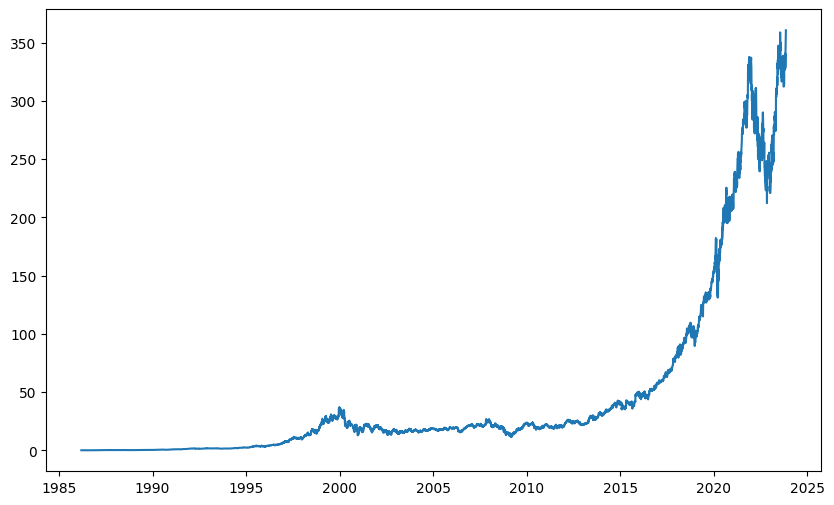

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])

In [4]:
# Choose the amount of days to consider from the dataset
days = 2000

# numbers of days to consider in the input of the model
lookback = 7 # a single week


def df_to_windowed(df, n=lookback):
  data = pd.DataFrame()
  for i in range(n, 0, -1):
    data[f"Last-{i} Price"] = df["Price"].shift(periods=i)
  data["Price"] = df["Price"]
  return data.dropna()

# Convert to a windowed Dataframe,
# so the last day prices (input) can predict the next day price (output)
windowed_df = df_to_windowed(df)

# Select the amount of data
windowed_df = windowed_df[-days:]

windowed_df

,Last-7 Price,Last-6 Price,Last-5 Price,Last-4 Price,Last-3 Price,Last-2 Price,Last-1 Price,Price
Date,,,,,,,,
2015-11-27,47.168167,47.951786,48.031929,48.254543,48.254543,48.307976,47.809322,48.023026
2015-11-30,47.951786,48.031929,48.254543,48.254543,48.307976,47.809322,48.023026,48.397011
2015-12-01,48.031929,48.254543,48.254543,48.307976,47.809322,48.023026,48.397011,49.171726
2015-12-02,48.254543,48.254543,48.307976,47.809322,48.023026,48.397011,49.171726,49.162815
2015-12-03,48.254543,48.307976,47.809322,48.023026,48.397011,49.171726,49.162815,48.263447
...,...,...,...,...,...,...,...,...
2023-11-01,329.320007,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007
2023-11-02,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007
2023-11-03,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007,352.799988


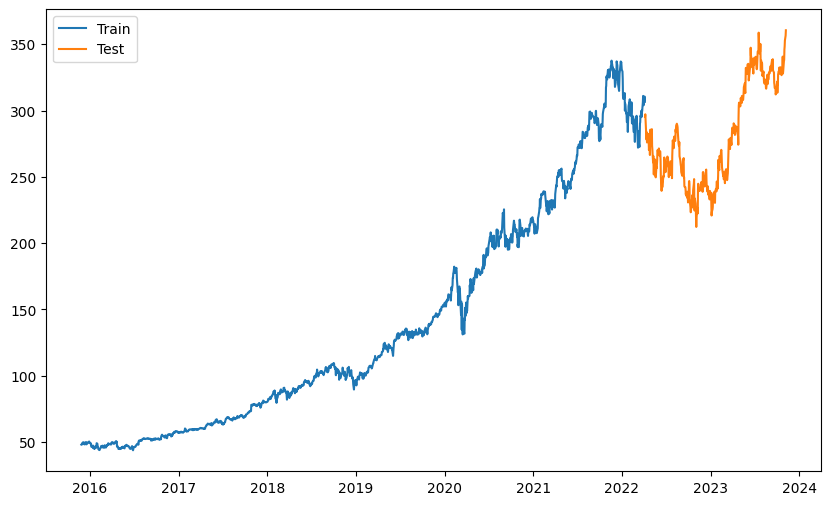

In [5]:
# Separate data into 80% training and 20% test
q80 = int(len(windowed_df) * 0.8)

windowed_df_train = windowed_df.iloc[:q80, :]
windowed_df_test = windowed_df.iloc[q80:, :]

plt.figure(figsize=(10,6))
plt.plot(windowed_df_train.index, windowed_df_train["Price"])
plt.plot(windowed_df_test.index, windowed_df_test["Price"])
plt.legend(["Train", "Test"])

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train = scaler.fit_transform(windowed_df_train)
scaled_test = scaler.transform(windowed_df_test)

scaled_train, scaled_test

(array([[0.01166893, 0.01433537, 0.01460807, ..., 0.01554738, 0.0138506 ,
         0.01457778],
        [0.01433537, 0.01460807, 0.01536557, ..., 0.0138506 , 0.01457778,
         0.01585034],
        [0.01460807, 0.01536557, 0.01536557, ..., 0.01457778, 0.01585034,
         0.01848649],
        ...,
        [0.85602102, 0.87148862, 0.87007937, ..., 0.90423548, 0.88561406,
         0.88933839],
        [0.87148862, 0.87007937, 0.89363301, ..., 0.88561406, 0.88933839,
         0.9079598 ],
        [0.87007937, 0.89363301, 0.90943614, ..., 0.88933839, 0.9079598 ,
         0.89423707]]),
 array([[0.89363301, 0.90943614, 0.90423548, ..., 0.9079598 , 0.89423707,
         0.85605477],
        [0.90943614, 0.90423548, 0.88561406, ..., 0.89423707, 0.85605477,
         0.86232885],
        [0.90423548, 0.88561406, 0.88933839, ..., 0.85605477, 0.86232885,
         0.84756603],
        ...,
        [1.01037453, 0.96688773, 0.9734209 , ..., 1.02874921, 1.03640534,
         1.05164948],
        [0.9

In [7]:
def split_columns(scaled_array, windowed):
  return (windowed.index, scaled_array[:, 0:-1], scaled_array[:, -1])

dates_train, X_train, Y_train = split_columns(scaled_train, windowed_df_train)
dates_test, X_test, Y_test = split_columns(scaled_test, windowed_df_test)

## Model Training

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Maybe adjust hyper parameters

model = Sequential([
    layers.Input((lookback, 1)),
    layers.Conv1D(128, kernel_size=5),
    layers.Conv1D(128, kernel_size=3),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.01), # avoid overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

model.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["mean_absolute_error"] # extra metrics
  )

model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
50/50 [==============================] - 11s 18ms/step - loss: 0.1476 - mean_absolute_error: 0.2788
Epoch 2/100
50/50 [==============================] - 1s 22ms/step - loss: 0.0170 - mean_absolute_error: 0.0910
Epoch 3/100
50/50 [==============================] - 1s 22ms/step - loss: 0.0021 - mean_absolute_error: 0.0381
Epoch 4/100
50/50 [==============================] - 1s 21ms/step - loss: 9.0162e-04 - mean_absolute_error: 0.0237
Epoch 5/100
50/50 [==============================] - 1s 16ms/step - loss: 6.7313e-04 - mean_absolute_error: 0.0198
Epoch 6/100
50/50 [==============================] - 1s 13ms/step - loss: 5.1957e-04 - mean_absolute_error: 0.0176
Epoch 7/100
50/50 [==============================] - 1s 13ms/step - loss: 5.2493e-04 - mean_absolute_error: 0.0159
Epoch 8/100
50/50 [==============================] - 1s 13ms/step - loss: 3.4495e-04 - mean_absolute_error: 0.0122
Epoch 9/100
50/50 [==============================] - 1s 13ms/step - loss: 3.6803e-04 - mean

## Results

In [9]:
import numpy as np

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_results = np.hstack((X_train, train_predictions))
test_results = np.hstack((X_test, test_predictions))

train_results = scaler.inverse_transform(train_results)
test_results = scaler.inverse_transform(test_results)

results_np = np.concatenate((train_results, test_results))

results_df = windowed_df.copy()

results_np.shape

for i in range(lookback, 0, -1):
  results_df[f"Last-{i} Price"] = results_np[:, lookback-i]

results_df["Price"] = results_np[:, lookback]

results_df

13/13 [==============================] - 2s 6ms/step


,Last-7 Price,Last-6 Price,Last-5 Price,Last-4 Price,Last-3 Price,Last-2 Price,Last-1 Price,Price
Date,,,,,,,,
2015-11-27,47.168167,47.951786,48.031929,48.254543,48.254543,48.307976,47.809322,47.860650
2015-11-30,47.951786,48.031929,48.254543,48.254543,48.307976,47.809322,48.023026,47.810460
2015-12-01,48.031929,48.254543,48.254543,48.307976,47.809322,48.023026,48.397011,47.873347
2015-12-02,48.254543,48.254543,48.307976,47.809322,48.023026,48.397011,49.171726,48.182078
2015-12-03,48.254543,48.307976,47.809322,48.023026,48.397011,49.171726,49.162815,48.516263
...,...,...,...,...,...,...,...,...
2023-11-01,329.320007,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,331.524981
2023-11-02,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,335.209278
2023-11-03,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007,339.397953


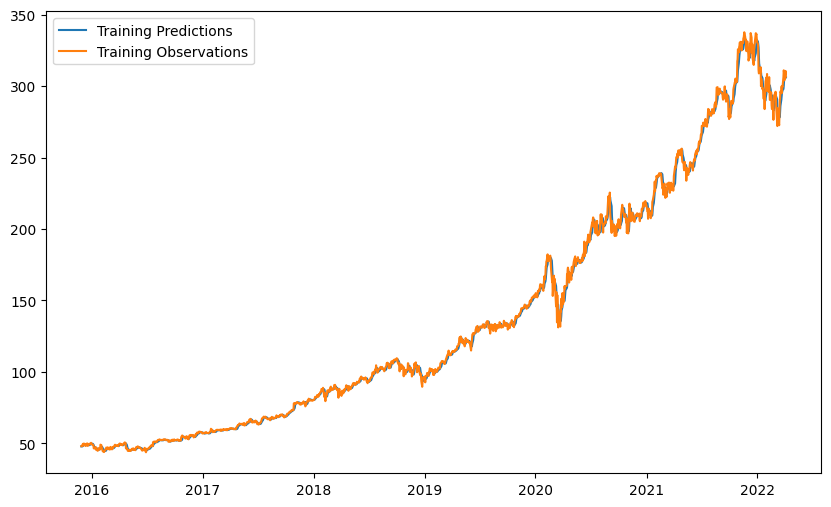

In [10]:
plt.figure(figsize=(10,6))
plt.plot(dates_train, results_df["Price"].iloc[:q80])
plt.plot(dates_train, windowed_df["Price"].iloc[:q80])
plt.legend(["Training Predictions", "Training Observations"])

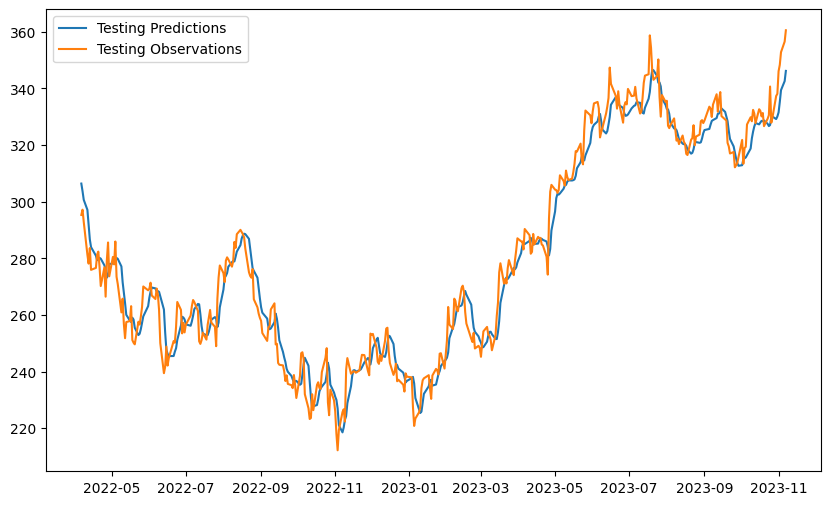

In [11]:
plt.figure(figsize=(10,6))
plt.plot(dates_test, results_df["Price"].iloc[q80:])
plt.plot(dates_test, windowed_df["Price"].iloc[q80:])
plt.legend(["Testing Predictions", "Testing Observations"])

## Evaluation Metrics:

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("For the Testing Prediction curve")
print("Mean Absolute Error: ", mean_absolute_error(y_true=windowed_df["Price"].iloc[q80:], y_pred=results_df["Price"].iloc[q80:]))
print("Mean Square Error: ", mean_squared_error(y_true=windowed_df["Price"].iloc[q80:], y_pred=results_df["Price"].iloc[q80:]))

For the Testing Prediction curve
Mean Absolute Error:  5.5288318822534555
Mean Square Error:  48.83610935258528



## Using the same model for another market

Checking model's generalization capabilities

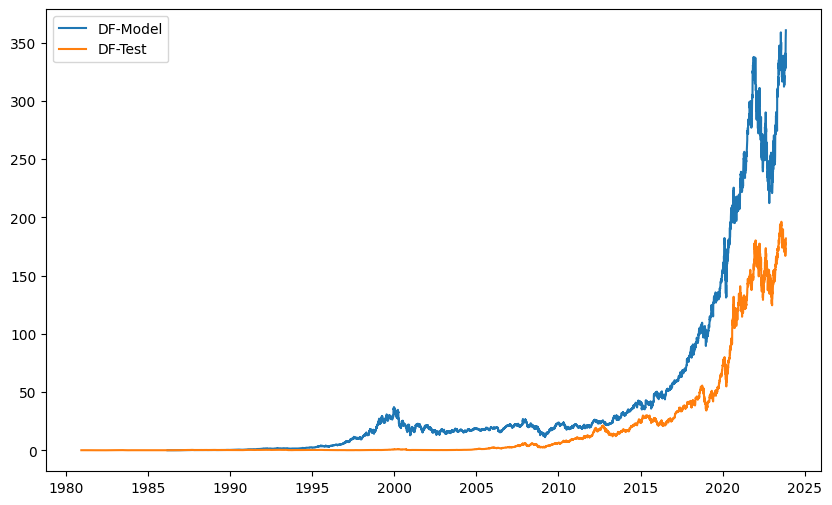

In [19]:
# Test Dataset
df2 = load_df("AAPL.csv")

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])
plt.plot(df2.index, df2["Price"])
plt.legend(["DF-Model", "DF-Test"])

63/63 [==============================] - 0s 7ms/step


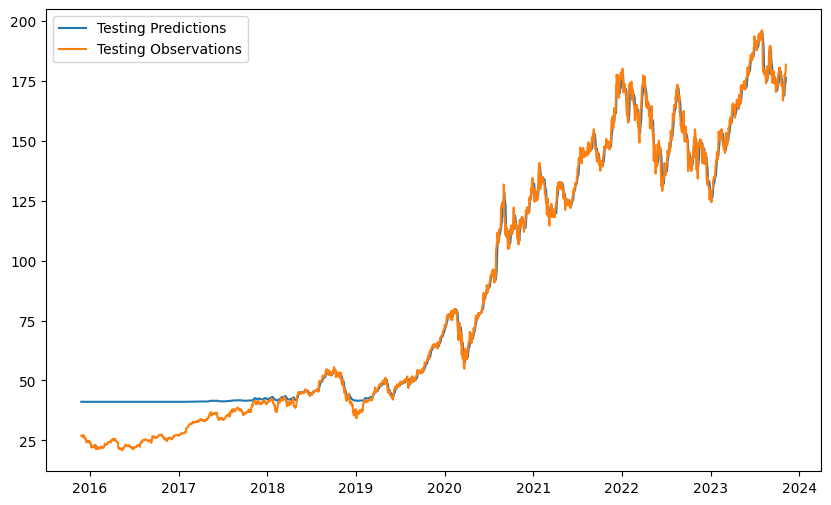

In [24]:
windowed_df2 = df_to_windowed(df2)

windowed_df2 = windowed_df2[-days:]

scaled_df2 = scaler.transform(windowed_df2)

dates2, X_test2, Y_test2 = split_columns(scaled_df2, windowed_df2)

Y2_pred = model.predict(X_test2)

test_results2 = np.hstack((X_test2, Y2_pred))

train_results2 = scaler.inverse_transform(test_results2)[:, -1]

plt.figure(figsize=(10,6))
plt.plot(dates2, train_results2)
plt.plot(dates2, windowed_df2["Price"])

plt.legend([
    "Testing Predictions",
    "Testing Observations"
])

In [23]:
print("Mean Absolute Error: ", mean_absolute_error(y_true=windowed_df2["Price"], y_pred=train_results2))
print("Mean Square Error: ", mean_squared_error(y_true=windowed_df2["Price"], y_pred=train_results2))

Mean Absolute Error:  4.676610949775555
Mean Square Error:  51.80627751668333
